# 🧠 DSSM Homework: Improve the Model

Welcome! This assignment builds upon the DSSM model you studied during the seminar.

Your task is to **improve the DSSM model** by modifying the architecture, loss function, evaluation, or training pipeline. This is an open-ended assignment meant to encourage exploration.

In this seminar, you've explored a basic implementation of the Deep Structured Semantic Model (DSSM).

Your task is to **improve this model** in one or more of the following directions:

### ✅ Model Improvements
- Replace MLP towers with Transformer or RNN encoders or etc. (5 баллов)
- Use different triplet loss. (3 балла)
- Add dropout, batch normalization, or layer norm. (3 балла)
- Integrate embeddings instead of one-hot vectors. (5 баллов)
- Visualize similarity distribution for positive vs. negative pairs. (5 баллов)

### ✅ Evaluation & Analysis
- Visualize embeddings using t-SNE or UMAP. (3 баллов)
- Develop and improve beyond accuracy metrics. (5 баллов)

### 📄 Deliverables
- Explain what you changed and why in the final markdown cell. (3 балла)
- Keep code modular, clean, and well-documented. (3 балла)

### 📝 Production
- create service based on DSSM vectors with ANN. (8 баллов)

### 📝 Leaderboard
- Improve score from UserKNN via DSSM (8 баллов)


Максимум баллов, которые можно получить - 25.

In [1]:
# ----------------------
# 2. IMPORTS AND SETUP
# ----------------------
import os
import requests
import zipfile
from tqdm.auto import tqdm
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import OneHotEncoder
from collections import Counter
import warnings
from sklearn.preprocessing import LabelEncoder

warnings.filterwarnings("ignore")

In [2]:
# ----------------------
# 3. DOWNLOAD AND LOAD DATA
# ----------------------
def download_and_extract():
    url = 'https://github.com/irsafilo/KION_DATASET/raw/f69775be31fa5779907cf0a92ddedb70037fb5ae/data_original.zip'
    filename = 'kion_train.zip'

    response = requests.get(url, stream=True)
    with open(filename, 'wb') as f:
        total = int(response.headers.get('content-length', 0))
        progress = tqdm(response.iter_content(1024 * 1024),
                        f"Downloading {filename}",
                        total=total // (1024 * 1024), unit='MB')
        for chunk in progress:
            f.write(chunk)

    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall("data")
    os.remove(filename)

if not os.path.exists("data/data_original"):
    download_and_extract()



In [21]:
# ----------------------
# 4. DATA PREPROCESSING
# ----------------------
interactions_df = pd.read_csv('data/data_original/interactions.csv')
users_df = pd.read_csv('data/data_original/users.csv')
items_df = pd.read_csv('data/data_original/items.csv')

# Integrate embeddings instead of one-hot vectors. (5 баллов)


In [22]:
def encode_features(df, features):
    encoded_feats = {}
    for feat in features:
        le = LabelEncoder()
        df[feat] = le.fit_transform(df[feat].astype(str))
        encoded_feats[feat] = df[feat].nunique()
    return df, encoded_feats

In [26]:
user_cat_feats = ["age", "income", "sex", "kids_flg"]
item_cat_feats = ['content_type', 'release_year', 'for_kids', 'age_rating', 'studios', 'countries', 'directors']

users_df, user_feat_dims = encode_features(users_df, user_cat_feats)
items_df, item_feat_dims = encode_features(items_df, item_cat_feats)

In [27]:
print(f"N users before: {interactions_df.user_id.nunique()}")
print(f"N items before: {interactions_df.item_id.nunique()}\n")

# отфильтруем все события взаимодействий, в которых пользователь посмотрел
# фильм менее чем на 10 процентов
interactions_df = interactions_df[interactions_df.watched_pct > 10]

# соберем всех пользователей, которые посмотрели
# больше 10 фильмов (можете выбрать другой порог)
valid_users = []

c = Counter(interactions_df.user_id)
for user_id, entries in c.most_common():
    if entries > 10:
        valid_users.append(user_id)

# и соберем все фильмы, которые посмотрели больше 10 пользователей
valid_items = []

c = Counter(interactions_df.item_id)
for item_id, entries in c.most_common():
    if entries > 10:
        valid_items.append(item_id)

# отбросим непопулярные фильмы и неактивных юзеров
interactions_df = interactions_df[interactions_df.user_id.isin(valid_users)]
interactions_df = interactions_df[interactions_df.item_id.isin(valid_items)]

print(f"N users after: {interactions_df.user_id.nunique()}")
print(f"N items after: {interactions_df.item_id.nunique()}")

N users before: 79515
N items before: 6901

N users after: 78970
N items after: 5976


In [29]:
common_users = set(interactions_df.user_id.unique()).intersection(set(users_df.user_id.unique()))
common_items = set(interactions_df.item_id.unique()).intersection(set(items_df.item_id.unique()))

print(len(common_users))
print(len(common_items))

interactions_df = interactions_df[interactions_df.item_id.isin(common_items)]
interactions_df = interactions_df[interactions_df.user_id.isin(common_users)]

items_encoded_df = items_df[items_df.item_id.isin(common_items)]
users_encoded_df = users_df[users_df.user_id.isin(common_users)]

65552
5974


In [30]:
interactions_df["uid"] = interactions_df["user_id"].astype("category")
interactions_df["uid"] = interactions_df["uid"].cat.codes

interactions_df["iid"] = interactions_df["item_id"].astype("category")
interactions_df["iid"] = interactions_df["iid"].cat.codes

print(sorted(interactions_df.iid.unique())[:5])
print(sorted(interactions_df.uid.unique())[:5])
interactions_df.head()

[np.int16(0), np.int16(1), np.int16(2), np.int16(3), np.int16(4)]
[np.int32(0), np.int32(1), np.int32(2), np.int32(3), np.int32(4)]


,user_id,item_id,last_watch_dt,total_dur,watched_pct,uid,iid
0,176549,9506,2021-05-11,4250,72.0,10561,3427
1,699317,1659,2021-05-29,8317,100.0,41858,582
6,1016458,354,2021-08-14,1672,25.0,60634,118
14,5324,8437,2021-04-18,6598,92.0,309,3025
18,927973,9617,2021-06-19,8422,100.0,55430,3456


In [31]:
interactions_vec = np.zeros((interactions_df.uid.nunique(),
                             interactions_df.iid.nunique()))

for user_id, item_id in zip(interactions_df.uid, interactions_df.iid):
    interactions_vec[user_id, item_id] += 1


res = interactions_vec.sum(axis=1)
for i in range(len(interactions_vec)):
    interactions_vec[i] /= res[i]

In [32]:
print(interactions_df.item_id.nunique())
print(items_encoded_df.item_id.nunique())
print(interactions_df.user_id.nunique())
print(users_encoded_df.user_id.nunique())

print(set(items_encoded_df.item_id.unique()) - set(interactions_df.item_id.unique()))

5974
5974
65552
65552
set()


In [33]:
iid_to_item_id = interactions_df[["iid", "item_id"]].drop_duplicates().set_index("iid").to_dict()["item_id"]
item_id_to_iid = interactions_df[["iid", "item_id"]].drop_duplicates().set_index("item_id").to_dict()["iid"]

uid_to_user_id = interactions_df[["uid", "user_id"]].drop_duplicates().set_index("uid").to_dict()["user_id"]
user_id_to_uid = interactions_df[["uid", "user_id"]].drop_duplicates().set_index("user_id").to_dict()["uid"]

In [34]:
items_encoded_df["iid"] = items_encoded_df["item_id"].apply(lambda x: item_id_to_iid[x])
items_encoded_df = items_encoded_df.set_index("iid")

users_encoded_df["uid"] = users_encoded_df["user_id"].apply(lambda x: user_id_to_uid[x])
users_encoded_df = users_encoded_df.set_index("uid")

In [35]:
N_FACTORS = 128

# в датасетах есть столбец user_id/item_id, помним, что он не является фичей для обучения!
ITEM_MODEL_SHAPE = (items_encoded_df.drop(["item_id"], axis=1).shape[1], )
USER_META_MODEL_SHAPE = (users_encoded_df.drop(["user_id"], axis=1).shape[1], )

USER_INTERACTION_MODEL_SHAPE = (interactions_vec.shape[1], )

print(f"N_FACTORS: {N_FACTORS}")
print(f"ITEM_MODEL_SHAPE: {ITEM_MODEL_SHAPE}")
print(f"USER_META_MODEL_SHAPE: {USER_META_MODEL_SHAPE}")
print(f"USER_INTERACTION_MODEL_SHAPE: {USER_INTERACTION_MODEL_SHAPE}")

N_FACTORS: 128
ITEM_MODEL_SHAPE: (13,)
USER_META_MODEL_SHAPE: (4,)
USER_INTERACTION_MODEL_SHAPE: (5974,)


# Add dropout, batch normalization, or layer norm. (3 балла)

# Replace MLP towers with Transformer or RNN encoders or etc. (5 баллов)

In [49]:
class ItemModel(nn.Module):
    def __init__(self, item_feat_dims, emb_dim=16, n_factors=128, nhead=4, num_layers=2):
        super().__init__()
        self.embeddings = nn.ModuleDict({
            feat: nn.Embedding(num_embeddings=dim, embedding_dim=emb_dim)
            for feat, dim in item_feat_dims.items()
        })

        self.pos_encoder = nn.Parameter(torch.zeros(1, len(item_feat_dims), emb_dim))

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=emb_dim,
            nhead=nhead,
            dim_feedforward=n_factors
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.fc = nn.Linear(emb_dim * len(item_feat_dims), n_factors)

    def forward(self, x_cat):
        embs = [self.embeddings[feat](x_cat[:, i]) for i, feat in enumerate(self.embeddings)]
        x = torch.stack(embs, dim=1)

        x = x + self.pos_encoder
        x = self.transformer_encoder(x)

        x = x.flatten(1)
        return self.fc(x)

class UserModel(nn.Module):
    def __init__(self, user_feat_dims, interaction_dim, emb_dim=16, n_factors=128):
        super().__init__()
        self.embeddings = nn.ModuleDict({
            feat: nn.Embedding(num_embeddings=dim, embedding_dim=emb_dim)
            for feat, dim in user_feat_dims.items()
        })

        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=emb_dim,
                nhead=2,
                dim_feedforward=n_factors
            ),
            num_layers=1
        )

        self.interaction_fc = nn.Linear(interaction_dim, n_factors)
        self.output_fc = nn.Linear(len(user_feat_dims)*emb_dim + n_factors, n_factors)

    def forward(self, x_cat, interaction):
        embs = [self.embeddings[feat](x_cat[:, i]) for i, feat in enumerate(self.embeddings)]
        embs = torch.stack(embs, dim=1)
        encoded = self.encoder(embs).flatten(1)
        interaction = torch.relu(self.interaction_fc(interaction))
        return self.output_fc(torch.cat([encoded, interaction], dim=1))



# Use different triplet loss. (3 балла)


In [50]:
def soft_margin_triplet_loss(anchor, positive, negative):
    pos_dist = torch.norm(anchor - positive, dim=1)
    neg_dist = torch.norm(anchor - negative, dim=1)
    loss = torch.log(1 + torch.exp(pos_dist - neg_dist))
    return loss.mean()

In [51]:
# Define the dataset
class RecSysDataset(Dataset):
    def __init__(self, users_df, items_df, interactions):
        self.users_cat = users_df[user_cat_feats].astype(int).values
        self.items_cat = items_df[item_cat_feats].astype(int).values
        self.interactions = interactions

    def __len__(self):
        return self.interactions.shape[0]

    def __getitem__(self, idx):
        uid = idx
        pos_i = np.random.choice(range(self.interactions.shape[1]), p=self.interactions[uid])
        neg_i = np.random.choice(range(self.interactions.shape[1]))

        uid_cat = self.users_cat[uid]
        uid_interaction = self.interactions[uid]
        pos_cat = self.items_cat[pos_i]
        neg_cat = self.items_cat[neg_i]

        return (
            torch.tensor(uid_cat, dtype=torch.long),
            torch.tensor(uid_interaction, dtype=torch.float32),
            torch.tensor(pos_cat, dtype=torch.long),
            torch.tensor(neg_cat, dtype=torch.long),
        )

In [52]:
user_model = UserModel(user_feat_dims, interaction_dim=interactions_vec.shape[1])
item_model = ItemModel(item_feat_dims)

optimizer = optim.Adam(list(user_model.parameters()) + list(item_model.parameters()), lr=0.001)

dataset = RecSysDataset(users_df, items_df, interactions_vec)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [53]:
import logging

In [54]:
from tqdm import tqdm
import logging

logging.basicConfig(filename='training.log', level=logging.INFO,
                    format='%(asctime)s - %(levelname)s - %(message)s')

def train_model(user_model, item_model, dataloader, optimizer, triplet_loss_fn, epochs=5, device='cpu'):
    user_model.to(device)
    item_model.to(device)

    for epoch in range(epochs):
        user_model.train()
        item_model.train()

        running_loss = 0.0
        batch_count = 0

        pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}", leave=False)
        for batch in pbar:
            uid_meta, uid_interaction, pos, neg = [x.to(device) for x in batch]

            optimizer.zero_grad()
            anchor = user_model(uid_meta, uid_interaction)
            positive = item_model(pos)
            negative = item_model(neg)

            loss = triplet_loss_fn(anchor, positive, negative)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            batch_count += 1

            pbar.set_postfix({'Batch Loss': loss.item()})

        avg_loss = running_loss / batch_count
        logging.info(f"Epoch {epoch+1}: Average Loss = {avg_loss:.4f}")
        print(f"[Epoch {epoch+1}] Average Loss: {avg_loss:.4f}")


In [62]:
triplet_loss = nn.TripletMarginLoss(margin=2.0, p=2)
train_model(user_model, item_model, dataloader, optimizer, triplet_loss, epochs=3, device='cuda' if torch.cuda.is_available() else 'cpu')

[Epoch 1] Average Loss: 0.0095


[Epoch 2] Average Loss: 0.0009


[Epoch 3] Average Loss: 0.0026


In [67]:
# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
user_model.to(device)
item_model.to(device)
user_model.eval()
item_model.eval()

# Get random user and item IDs
rand_uid = np.random.choice(users_encoded_df.index)
rand_iid = np.random.choice(items_encoded_df.index)

# Получаем настоящие user_id/item_id
true_uid = uid_to_user_id[rand_uid]
true_iid = iid_to_item_id[rand_iid]

# Извлекаем только нужные признаки
user_meta_feats = users_df.loc[users_df.user_id == true_uid, user_cat_feats].values.astype(np.int64)
user_interaction_vec = interactions_vec[rand_uid]
item_feats = items_df.loc[items_df.item_id == true_iid, item_cat_feats].values.astype(np.int64)

# Преобразуем в тензоры
user_meta_feats = torch.tensor(user_meta_feats, dtype=torch.long, device=device)
user_interaction_vec = torch.tensor(user_interaction_vec, dtype=torch.float32, device=device).unsqueeze(0)
item_feats = torch.tensor(item_feats, dtype=torch.long, device=device)

# Прогон через модель
with torch.no_grad():
    user_vec = user_model(user_meta_feats, user_interaction_vec)
    item_vec = item_model(item_feats)

# Расстояние
distance = torch.dist(user_vec, item_vec)
print(f"Distance between user {rand_uid} and item {rand_iid}: {distance.item():.4f}")


Distance between user 48409 and item 5284: 42.5577


In [68]:
# Prepare proper features
users_meta_feats = torch.tensor(users_df.loc[users_encoded_df.index, user_cat_feats].astype(int).values, dtype=torch.long, device=device)
users_interaction_vec = torch.tensor(interactions_vec, dtype=torch.float32, device=device)
items_feats = torch.tensor(items_df.loc[items_encoded_df.index, item_cat_feats].astype(int).values, dtype=torch.long, device=device)

# Get embeddings
with torch.no_grad():
    users_vec = user_model(users_meta_feats, users_interaction_vec)
    items_vec = item_model(items_feats)

# Compute distances and get top-10
dists = torch.cdist(users_vec, items_vec)  # [n_users, n_items]
top10_iids = torch.topk(dists, k=10, largest=False).indices

# Mapping back to IDs
top10_item_ids = np.vectorize(iid_to_item_id.get)(top10_iids.cpu().numpy())
user_ids = [uid_to_user_id[uid] for uid in range(top10_iids.shape[0])]

# Format output
df_dssm = pd.DataFrame({
    'user_id': user_ids,
    'item_id': list(top10_item_ids)
})
df_dssm = df_dssm.explode('item_id')
df_dssm['rank'] = df_dssm.groupby('user_id').cumcount() + 1
df_dssm = df_dssm.groupby('user_id').agg({'item_id': list}).reset_index()

df_dssm


,user_id,item_id
0,2,"[9728, 5370, 10379, 11800, 1691, 1453, 8083, 1..."
1,21,"[9728, 5370, 10379, 11800, 1691, 1453, 8083, 9..."
2,53,"[9728, 5370, 10379, 11800, 1691, 1453, 8083, 1..."
3,60,"[9728, 5370, 10379, 11800, 1691, 1453, 8083, 9..."
4,81,"[9728, 5370, 10379, 11800, 1691, 1453, 8083, 1..."
...,...,...
65547,1097486,"[9728, 5370, 10379, 11800, 1691, 1453, 8083, 1..."
65548,1097489,"[9728, 5370, 10379, 11800, 1691, 1453, 8083, 9..."
65549,1097508,"[9728, 5370, 10379, 11800, 1691, 1453, 8083, 9..."
65550,1097513,"[9728, 5370, 10379, 11800, 1691, 1453, 8083, 1..."


# Visualize similarity distribution for positive vs. negative pairs. (5 баллов)


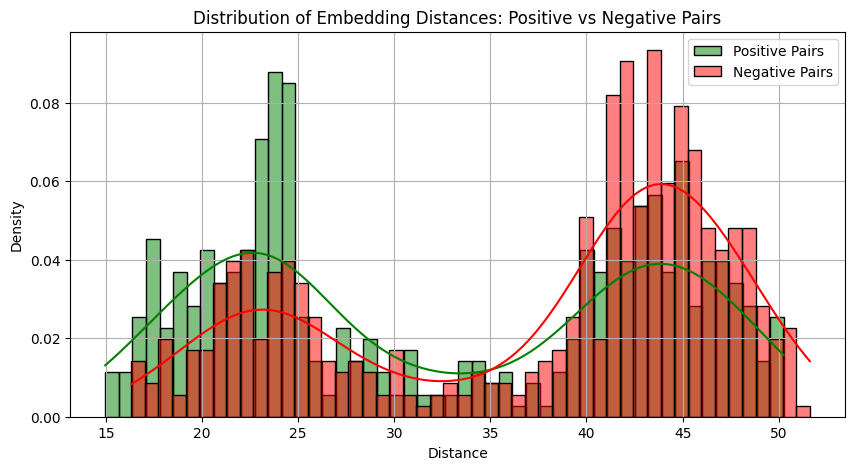

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt

np.random.seed(42)
sample_uids = np.random.choice(users_encoded_df.index, size=500, replace=False)

positive_dists = []
negative_dists = []

user_meta_feats = users_df.loc[sample_uids, user_cat_feats].astype(int).values
user_meta_feats = torch.tensor(user_meta_feats, dtype=torch.long, device=device)
user_interaction_feats = torch.tensor(interactions_vec[sample_uids], dtype=torch.float32, device=device)

with torch.no_grad():
    user_vecs = user_model(user_meta_feats, user_interaction_feats)

    for i, uid in enumerate(sample_uids):
        interacted_items = np.where(interactions_vec[uid] > 0)[0]
        if len(interacted_items) == 0:
            continue

        pos_iid = np.random.choice(interacted_items)
        neg_iid = np.random.choice([i for i in range(interactions_vec.shape[1]) if i not in interacted_items])

        pos_feats = items_df.loc[[pos_iid], item_cat_feats].astype(int).values
        neg_feats = items_df.loc[[neg_iid], item_cat_feats].astype(int).values

        pos_feats = torch.tensor(pos_feats, dtype=torch.long, device=device)
        neg_feats = torch.tensor(neg_feats, dtype=torch.long, device=device)

        pos_vec = item_model(pos_feats)
        neg_vec = item_model(neg_feats)

        pos_dist = torch.norm(user_vecs[i] - pos_vec.squeeze())
        neg_dist = torch.norm(user_vecs[i] - neg_vec.squeeze())

        positive_dists.append(pos_dist.item())
        negative_dists.append(neg_dist.item())


plt.figure(figsize=(10, 5))
sns.histplot(positive_dists, color='green', label='Positive Pairs', kde=True, stat="density", bins=50)
sns.histplot(negative_dists, color='red', label='Negative Pairs', kde=True, stat="density", bins=50)
plt.xlabel('Distance')
plt.ylabel('Density')
plt.title('Distribution of Embedding Distances: Positive vs Negative Pairs')
plt.legend()
plt.grid(True)
plt.show()

# Visualize embeddings using t-SNE or UMAP. (3 баллов)


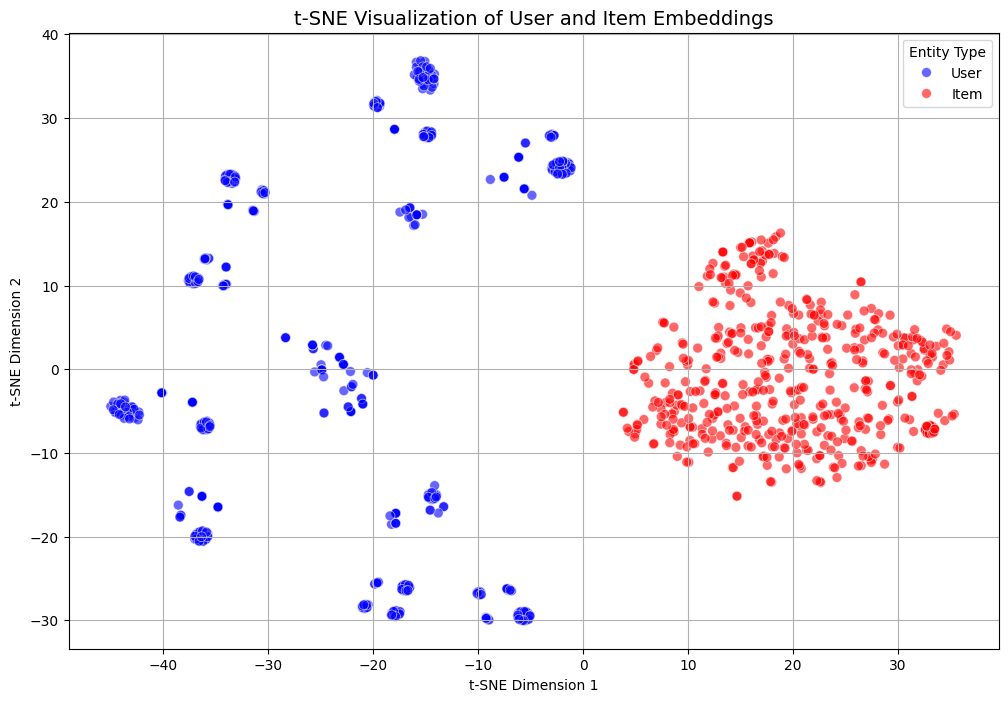

In [70]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

sample_size = 500
user_sample_idx = np.random.choice(range(users_vec.shape[0]), size=sample_size, replace=False)
item_sample_idx = np.random.choice(range(items_vec.shape[0]), size=sample_size, replace=False)

user_sample = users_vec[user_sample_idx].cpu().numpy()
item_sample = items_vec[item_sample_idx].cpu().numpy()

combined_embeddings = np.vstack([user_sample, item_sample])
labels = np.array(['User'] * sample_size + ['Item'] * sample_size)

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_2d = tsne.fit_transform(combined_embeddings)

plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=embeddings_2d[:, 0],
    y=embeddings_2d[:, 1],
    hue=labels,
    palette={'User': 'blue', 'Item': 'red'},
    alpha=0.6,
    s=50
)

plt.title('t-SNE Visualization of User and Item Embeddings', fontsize=14)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(title='Entity Type')
plt.grid(True)
plt.show()